# MD Fakrul Islam, Certified Data Scientist, Machine Learning, Deep Learning   Engineer and Big Data Professional
# Email: fakruldsebd@gmail.com
# Phone: +8801954345775
# https://www.linkedin.com/in/fakrul-islam-bd/
# https://github.com/aifakrul
## Contact for nlp/nlu, image, audio/speech, video processing and contextual ai in real time to solve your complex **Business AI Problem**

# Project Details


```
Identify diseases of below plants using convolutional neural networks (CNN), transfer learning strategy and multilevel classifications. 

Apple- 3 Deadly diseases
Grape- 3 Deadly diseases
Maize- 3 Deadly diseases
Potato- 2 Deadly diseases
Tomato- 9 Deadly diseases


You can collect the Dataset from my Google Drive:
https://drive.google.com/file/d/1odLdFTMf_U-SkCTa0JIWmzVFTmV14paO/view?usp=sharing


Assess the top layer accuracy of:

MobileNetV2
ResNet50V2
ResNet101V2
ResNet152V2
Xception
VGG16
VGG19
InceptionResNetV2
InceptionV3

To learn about the CNN, please visit

https://arxiv.org/
https://en.wikipedia.org/wiki/Convolutional_neural_network
https://www.tensorflow.org/federated

```



# Import Necessery Library

In [ ]:
import os, sys, math, time
import numpy as np
from matplotlib import pyplot as plt
if 'google.colab' in sys.modules: 
  %tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.2.0


# Mount the google drive drive to fetch datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Split Dataset into Training and Validation

In [ ]:
IMAGE_FILE_LOCATION = '/content/drive/My Drive/Plant_Disease_Clinic/Potato/*/*.JPG'
TF_RECORD_LOCATION = '/content/drive/My Drive/Plant_Disease_Clinic/potato_tfrecords/*.tfrec'

IMAGE_SIZE = [224, 224]

BATCH_SIZE = 64 # 128 works on GPU too but comes very close to the memory limit of the Colab GPU
EPOCHS=12

VALIDATION_SPLIT = 0.20
CLASSES = [b'Early_Blight', b'Healthy', b'Late_Blight'] # do not change, maps to the labels in the data (folder names)
NO_OF_CLASSES=len(CLASSES)
#CLASSES = [b'EarlyBlight', b'Healthy', b'LateBlight'] # Total Classes
total_image_files = len(tf.io.gfile.glob(IMAGE_FILE_LOCATION))

# splitting data files between training and validation
filenames = tf.io.gfile.glob(TF_RECORD_LOCATION)
split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]
print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
validation_steps = int(total_image_files // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(total_image_files // len(filenames) * len(training_filenames)) // BATCH_SIZE
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

#print(filenames)
#print(len(filenames))
#print(len(validation_filenames))
#print(len(training_filenames))
#print(validation_steps)
#print(steps_per_epoch)
#print(CLASSES)
#print(validation_filenames)
#print(training_filenames)

Pattern matches 16 data files. Splitting dataset into 13 training files and 3 validation files
With a batch size of 64, there will be 30 batches per training epoch and 6 batch(es) per validation run.


# Configure all utilities function

In [ ]:
def dataset_to_numpy_util(dataset, N):
  dataset = dataset.batch(N)
  
  for images, labels in dataset:
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    break;

  return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
  
def display_9_images_from_dataset(dataset):
  subplot=331
  plt.figure(figsize=(13,13))
  images, labels = dataset_to_numpy_util(dataset, 9)
  for i, image in enumerate(images):
    title = CLASSES[labels[i]]
    subplot = display_one_flower(image, title, subplot)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  classes = np.argmax(predictions, axis=-1)
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(classes[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

#Read images and labels from TFRecords

In [ ]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size will be needed for TPU
    class_label = example['class']
    return image, class_label

def load_dataset(filenames):
  # read from TFRecords. For optimal performance, read from multiple
  # TFRecord files at once and set the option experimental_deterministic = False
  # to allow order-altering optimizations.

  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  return dataset

# Display 9 images from training files

['/content/drive/My Drive/Plant_Disease_Clinic/potato_tfrecords/potato03-149.tfrec', '/content/drive/My Drive/Plant_Disease_Clinic/potato_tfrecords/potato04-149.tfrec', '/content/drive/My Drive/Plant_Disease_Clinic/potato_tfrecords/potato05-149.tfrec', '/content/drive/My Drive/Plant_Disease_Clinic/potato_tfrecords/potato06-149.tfrec', '/content/drive/My Drive/Plant_Disease_Clinic/potato_tfrecords/potato07-149.tfrec', '/content/drive/My Drive/Plant_Disease_Clinic/potato_tfrecords/potato08-149.tfrec', '/content/drive/My Drive/Plant_Disease_Clinic/potato_tfrecords/potato09-149.tfrec', '/content/drive/My Drive/Plant_Disease_Clinic/potato_tfrecords/potato10-149.tfrec', '/content/drive/My Drive/Plant_Disease_Clinic/potato_tfrecords/potato11-149.tfrec', '/content/drive/My Drive/Plant_Disease_Clinic/potato_tfrecords/potato12-149.tfrec', '/content/drive/My Drive/Plant_Disease_Clinic/potato_tfrecords/potato13-149.tfrec', '/content/drive/My Drive/Plant_Disease_Clinic/potato_tfrecords/potato14-149

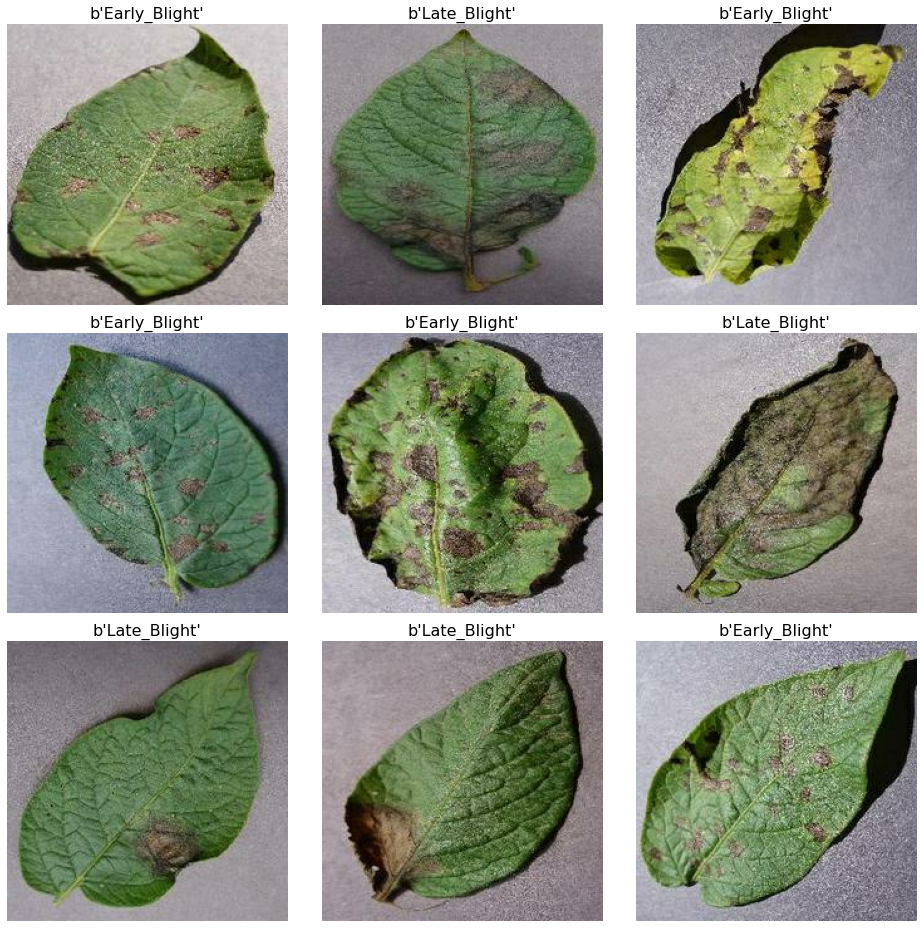

In [ ]:
print(training_filenames)
display_9_images_from_dataset(load_dataset(training_filenames))

# Display 9 images from validation files

['/content/drive/My Drive/Plant_Disease_Clinic/potato_tfrecords/potato00-149.tfrec', '/content/drive/My Drive/Plant_Disease_Clinic/potato_tfrecords/potato01-149.tfrec', '/content/drive/My Drive/Plant_Disease_Clinic/potato_tfrecords/potato02-149.tfrec']


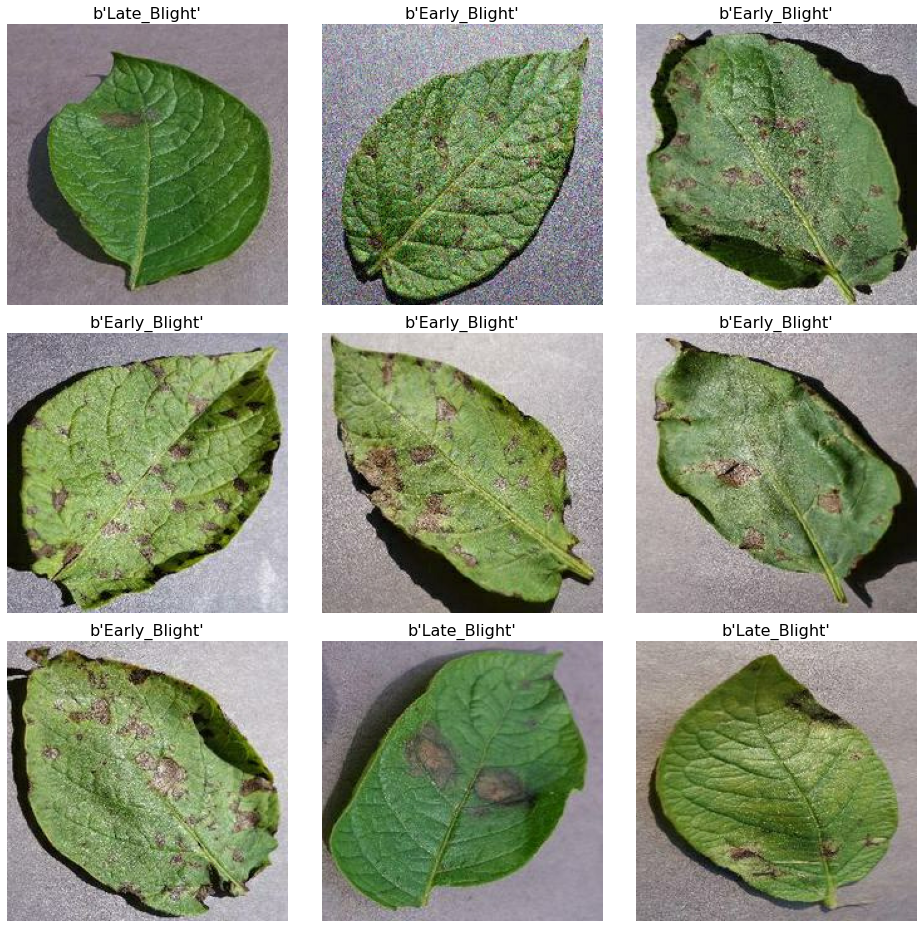

In [ ]:
print(validation_filenames)
display_9_images_from_dataset(load_dataset(validation_filenames))

# Prepare training and validation datasets and Load into RAM

In [ ]:
def get_batched_dataset(filenames, train=False):
  dataset = load_dataset(filenames)
  dataset = dataset.cache() # This dataset fits in RAM
  if train:
    # Best practices for Keras:
    # Training dataset: repeat then batch
    # Evaluation dataset: do not repeat
    dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  # should shuffle too but this dataset was well shuffled on disk already
  return dataset
  # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets

# instantiate the datasets
training_dataset = get_batched_dataset(training_filenames, train=True)
validation_dataset = get_batched_dataset(validation_filenames, train=False)

print(training_dataset)
print(validation_dataset)


<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>
<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>


# Model Creation(MobileNetV2)

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
pretrained_model.trainable = False

model_MobileNetV2 = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NO_OF_CLASSES, activation='softmax')
])

model_MobileNetV2.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_MobileNetV2.summary()
model_MobileNetV2.input_shape

9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               16056576  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 18,315,331
Trainable params: 16,057,347
Non-trainable params: 2,257,984
_________________________________________________________________


(None, 224, 224, 3)

# All Popular ResNet Models
# Model Creation (ResNet50V2)

In [ ]:
pretrained_model = tf.keras.applications.ResNet50V2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
pretrained_model.trainable = False

model_ResNet50V2 = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NO_OF_CLASSES, activation='softmax')
])

model_ResNet50V2.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_ResNet50V2.summary()
model_ResNet50V2.input_shape

94674944/94668760 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 7, 7, 2048)        23564800  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 771       
Total params: 49,255,939
Trainable params: 25,691,139
Non-trainable params: 23,564,800
_________________________________________________________________


(None, 224, 224, 3)

# Model Creation (ResNet101V2)

In [ ]:
pretrained_model = tf.keras.applications.ResNet101V2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
pretrained_model.trainable = False

model_ResNet101V2 = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NO_OF_CLASSES, activation='softmax')
])

model_ResNet101V2.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_ResNet101V2.summary()
model_ResNet101V2.input_shape

171319296/171317808 [==============================] - 2s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Model)          (None, 7, 7, 2048)        42626560  
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 771       
Total params: 68,317,699
Trainable params: 25,691,139
Non-trainable params: 42,626,560
_________________________________________________________________


(None, 224, 224, 3)

# Model Creation (ResNet152V2)

In [ ]:
pretrained_model = tf.keras.applications.ResNet152V2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
pretrained_model.trainable = False

model_ResNet152V2 = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NO_OF_CLASSES, activation='softmax')
])

model_ResNet152V2.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_ResNet152V2.summary()
model_ResNet152V2.input_shape

234553344/234545216 [==============================] - 2s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Model)          (None, 7, 7, 2048)        58331648  
_________________________________________________________________
flatten_3 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 771       
Total params: 84,022,787
Trainable params: 25,691,139
Non-trainable params: 58,331,648
_________________________________________________________________


(None, 224, 224, 3)

# Model Creation Xception

In [ ]:
pretrained_model = tf.keras.applications.Xception(input_shape=[*IMAGE_SIZE, 3], include_top=False)
pretrained_model.trainable = False

model_Xception = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NO_OF_CLASSES, activation='softmax')
])

model_Xception.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_Xception.summary()
model_Xception.input_shape

83689472/83683744 [==============================] - 1s 0us/step
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten_4 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 771       
Total params: 46,552,619
Trainable params: 25,691,139
Non-trainable params: 20,861,480
_________________________________________________________________


(None, 224, 224, 3)

# All VGG Models
# Model Creation VGG16

In [ ]:
pretrained_model = tf.keras.applications.VGG16(input_shape=[*IMAGE_SIZE, 3], include_top=False)
pretrained_model.trainable = False

model_VGG16 = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NO_OF_CLASSES, activation='softmax')
])

model_VGG16.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_VGG16.summary()
model_VGG16.input_shape

58892288/58889256 [==============================] - 1s 0us/step
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 771       
Total params: 21,138,243
Trainable params: 6,423,555
Non-trainable params: 14,714,688
_________________________________________________________________


(None, 224, 224, 3)

# Model Creation VGG19

In [ ]:
pretrained_model = tf.keras.applications.VGG19(input_shape=[*IMAGE_SIZE, 3], include_top=False)
pretrained_model.trainable = False

model_VGG19 = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NO_OF_CLASSES, activation='softmax')
])

model_VGG19.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_VGG19.summary()
model_VGG19.input_shape

80142336/80134624 [==============================] - 0s 0us/step
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_6 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 771       
Total params: 26,447,939
Trainable params: 6,423,555
Non-trainable params: 20,024,384
_________________________________________________________________


(None, 224, 224, 3)

# Model Creation InceptionResNetV2

In [ ]:
pretrained_model = tf.keras.applications.InceptionResNetV2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
pretrained_model.trainable = False

model_InceptionResNetV2 = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NO_OF_CLASSES, activation='softmax')
])

model_InceptionResNetV2.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_InceptionResNetV2.summary()
model_InceptionResNetV2.input_shape

219062272/219055592 [==============================] - 2s 0us/step
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 5, 5, 1536)        54336736  
_________________________________________________________________
flatten_7 (Flatten)          (None, 38400)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               9830656   
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 771       
Total params: 64,168,163
Trainable params: 9,831,427
Non-trainable params: 54,336,736
_________________________________________________________________


(None, 224, 224, 3)

# Model Creation InceptionV3

In [ ]:
pretrained_model = tf.keras.applications.InceptionV3(input_shape=[*IMAGE_SIZE, 3], include_top=False)
pretrained_model.trainable = False

model_InceptionV3 = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NO_OF_CLASSES, activation='softmax')
])

model_InceptionV3.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_InceptionV3.summary()
model_InceptionV3.input_shape

87916544/87910968 [==============================] - 1s 0us/step
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_8 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               13107456  
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 771       
Total params: 34,911,011
Trainable params: 13,108,227
Non-trainable params: 21,802,784
_________________________________________________________________


(None, 224, 224, 3)

In [ ]:
# Create List to store Training Time, Training Accuracy, Training Loss, Validation Accuracy, Validation Loss
training_details=[]

#Train the model(MobileNetV2)

In [ ]:
start_time = time.time()
history = model_MobileNetV2.fit(training_dataset.repeat(), steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_dataset.repeat(), validation_steps=validation_steps, shuffle=True)
final_accuracy = history.history["val_accuracy"][-5:]
model_MobileNetV2_accuracy=round(np.mean(final_accuracy),2)
model_MobileNetV2_training_time= round((time.time() - start_time),2)
print("FINAL ACCURACY MEAN(MobileNetV2): ", model_MobileNetV2_accuracy)
print("TRAINING TIME: ", model_MobileNetV2_training_time , " sec")

Epoch 1/12
30/30 [==============================] - 4s 126ms/step - loss: 6.5449 - accuracy: 0.7974 - val_loss: 0.6355 - val_accuracy: 0.9375
Epoch 2/12
30/30 [==============================] - 2s 71ms/step - loss: 0.3876 - accuracy: 0.9484 - val_loss: 0.1263 - val_accuracy: 0.9740
Epoch 3/12
30/30 [==============================] - 2s 71ms/step - loss: 0.0923 - accuracy: 0.9771 - val_loss: 0.1259 - val_accuracy: 0.9714
Epoch 4/12
30/30 [==============================] - 2s 71ms/step - loss: 0.0387 - accuracy: 0.9870 - val_loss: 0.1283 - val_accuracy: 0.9688
Epoch 5/12
30/30 [==============================] - 2s 71ms/step - loss: 0.0600 - accuracy: 0.9839 - val_loss: 0.1144 - val_accuracy: 0.9714
Epoch 6/12
30/30 [==============================] - 2s 70ms/step - loss: 0.0268 - accuracy: 0.9901 - val_loss: 0.1023 - val_accuracy: 0.9740
Epoch 7/12
30/30 [==============================] - 2s 70ms/step - loss: 0.0233 - accuracy: 0.9906 - val_loss: 0.0986 - val_accuracy: 0.9766
Epoch 8/12
3

# Training and Validation Accuracy Graph(MobileNetv2)
# Training and Validation Loss Graph(MobileNetv2)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


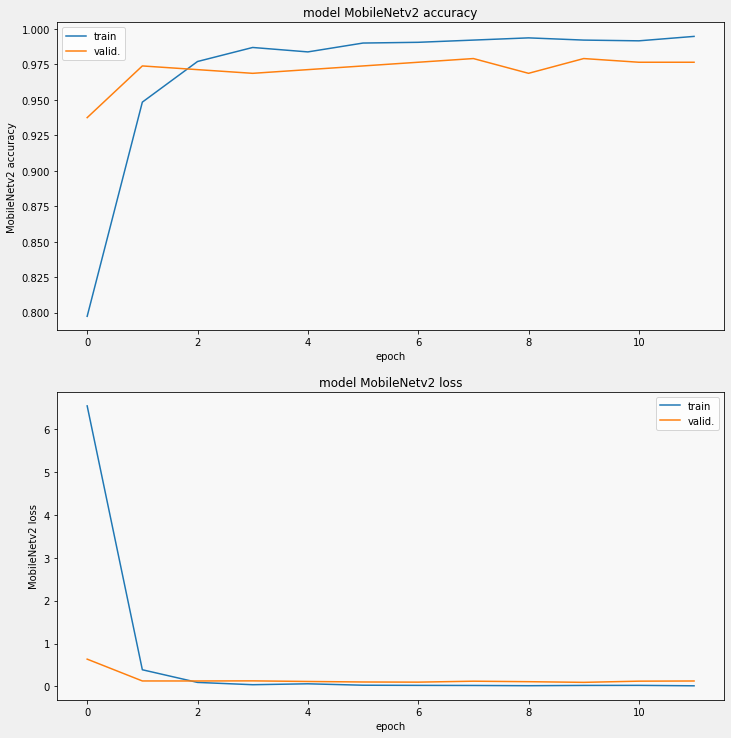

In [ ]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'MobileNetv2 accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'MobileNetv2 loss', 212)

# Train the model(ResNet50V2)

In [ ]:
start_time = time.time()
history = model_ResNet50V2.fit(training_dataset.repeat(), steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_dataset.repeat(), validation_steps=validation_steps, shuffle=True)
final_accuracy = history.history["val_accuracy"][-5:]
model_ResNet50V2_accuracy=round(np.mean(final_accuracy),2)
model_ResNet50V2_training_time= round((time.time() - start_time),2)
print("FINAL ACCURACY MEAN(ResNet50V2): ", model_ResNet50V2_accuracy)
print("TRAINING TIME: ", model_ResNet50V2_training_time , " sec")


Epoch 1/12
30/30 [==============================] - 4s 147ms/step - loss: 6.6833 - accuracy: 0.7771 - val_loss: 0.6397 - val_accuracy: 0.9167
Epoch 2/12
30/30 [==============================] - 4s 122ms/step - loss: 0.3181 - accuracy: 0.9365 - val_loss: 0.2006 - val_accuracy: 0.9427
Epoch 3/12
30/30 [==============================] - 4s 122ms/step - loss: 0.0882 - accuracy: 0.9667 - val_loss: 0.1922 - val_accuracy: 0.9635
Epoch 4/12
30/30 [==============================] - 4s 122ms/step - loss: 0.0552 - accuracy: 0.9797 - val_loss: 0.1950 - val_accuracy: 0.9531
Epoch 5/12
30/30 [==============================] - 4s 122ms/step - loss: 0.0359 - accuracy: 0.9891 - val_loss: 0.2113 - val_accuracy: 0.9479
Epoch 6/12
30/30 [==============================] - 4s 123ms/step - loss: 0.0284 - accuracy: 0.9922 - val_loss: 0.1820 - val_accuracy: 0.9583
Epoch 7/12
30/30 [==============================] - 4s 123ms/step - loss: 0.0226 - accuracy: 0.9932 - val_loss: 0.1768 - val_accuracy: 0.9531
Epoch 

# Training and Validation Accuracy Graph(ResNet50V2)
# Training and Validation Loss Graph(ResNet50V2)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


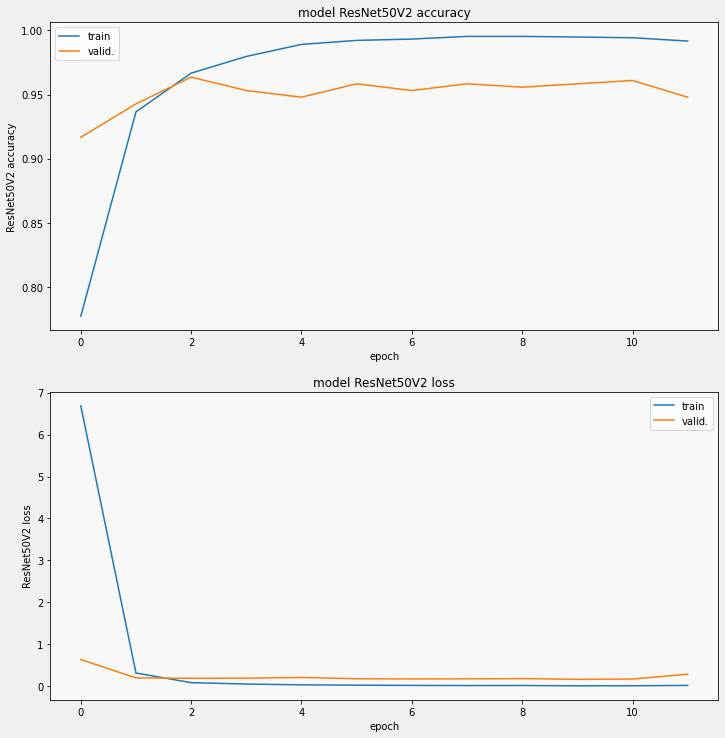

In [ ]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'ResNet50V2 accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'ResNet50V2 loss', 212)

# Train the model(ResNet101V2)

In [ ]:
start_time = time.time()
history = model_ResNet101V2.fit(training_dataset.repeat(), steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_dataset.repeat(), validation_steps=validation_steps, shuffle=True)
final_accuracy = history.history["val_accuracy"][-5:]
model_ResNet101V2_accuracy=round(np.mean(final_accuracy),2)
model_ResNet101V2_training_time= round((time.time() - start_time),2)
print("FINAL ACCURACY MEAN(ResNet101V2): ", model_ResNet101V2_accuracy)
print("TRAINING TIME: ", model_ResNet101V2_training_time , " sec")

Epoch 1/12
30/30 [==============================] - 7s 246ms/step - loss: 7.4100 - accuracy: 0.8021 - val_loss: 0.7132 - val_accuracy: 0.9036
Epoch 2/12
30/30 [==============================] - 6s 201ms/step - loss: 0.2991 - accuracy: 0.9375 - val_loss: 0.2262 - val_accuracy: 0.9271
Epoch 3/12
30/30 [==============================] - 6s 200ms/step - loss: 0.1266 - accuracy: 0.9557 - val_loss: 0.1972 - val_accuracy: 0.9479
Epoch 4/12
30/30 [==============================] - 6s 200ms/step - loss: 0.0798 - accuracy: 0.9693 - val_loss: 0.1798 - val_accuracy: 0.9401
Epoch 5/12
30/30 [==============================] - 6s 200ms/step - loss: 0.0521 - accuracy: 0.9776 - val_loss: 0.2077 - val_accuracy: 0.9427
Epoch 6/12
30/30 [==============================] - 6s 200ms/step - loss: 0.0576 - accuracy: 0.9760 - val_loss: 0.2386 - val_accuracy: 0.9453
Epoch 7/12
30/30 [==============================] - 6s 200ms/step - loss: 0.0405 - accuracy: 0.9812 - val_loss: 0.2410 - val_accuracy: 0.9453
Epoch 

# Training and Validation Accuracy Graph(ResNet101V2)
# Training and Validation Loss Graph(ResNet101V2)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


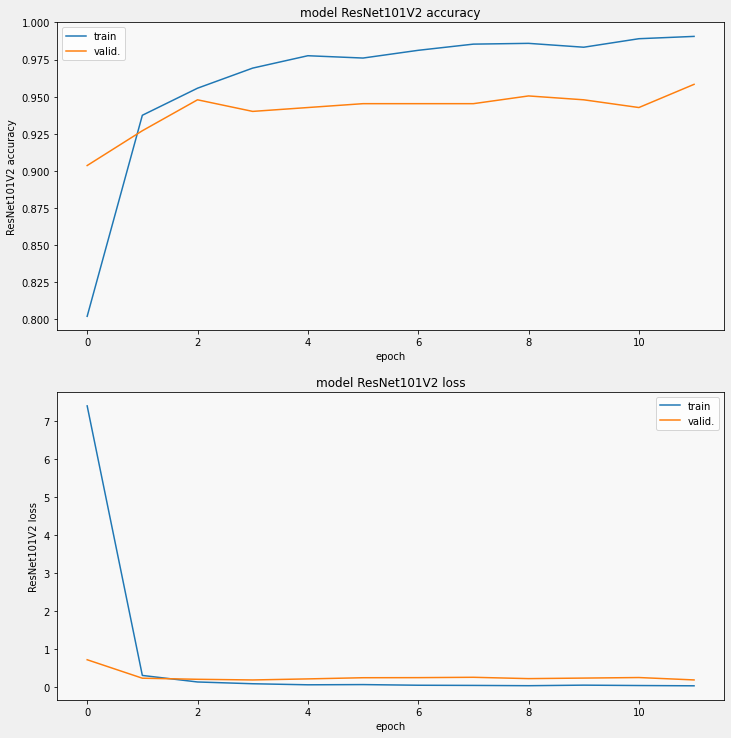

In [ ]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'ResNet101V2 accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'ResNet101V2 loss', 212)

# Train the model(ResNet152V2)

In [ ]:
start_time = time.time()
history = model_ResNet152V2.fit(training_dataset.repeat(), steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_dataset.repeat(), validation_steps=validation_steps, shuffle=True)
final_accuracy = history.history["val_accuracy"][-5:]

model_ResNet152V2_accuracy=round(np.mean(final_accuracy),2)
model_ResNet152V2_training_time= round((time.time() - start_time),2)
print("FINAL ACCURACY MEAN(ResNet152V2): ", model_ResNet152V2_accuracy)
print("TRAINING TIME: ", model_ResNet152V2_training_time , " sec")

Epoch 1/12
30/30 [==============================] - 11s 351ms/step - loss: 6.5622 - accuracy: 0.7958 - val_loss: 0.2911 - val_accuracy: 0.9062
Epoch 2/12
30/30 [==============================] - 8s 283ms/step - loss: 0.2559 - accuracy: 0.9276 - val_loss: 0.1905 - val_accuracy: 0.9349
Epoch 3/12
30/30 [==============================] - 8s 283ms/step - loss: 0.1515 - accuracy: 0.9516 - val_loss: 0.1612 - val_accuracy: 0.9609
Epoch 4/12
30/30 [==============================] - 8s 283ms/step - loss: 0.1088 - accuracy: 0.9729 - val_loss: 0.1340 - val_accuracy: 0.9479
Epoch 5/12
30/30 [==============================] - 8s 283ms/step - loss: 0.0718 - accuracy: 0.9714 - val_loss: 0.1339 - val_accuracy: 0.9583
Epoch 6/12
30/30 [==============================] - 8s 283ms/step - loss: 0.0513 - accuracy: 0.9807 - val_loss: 0.1148 - val_accuracy: 0.9635
Epoch 7/12
30/30 [==============================] - 8s 283ms/step - loss: 0.0489 - accuracy: 0.9792 - val_loss: 0.0998 - val_accuracy: 0.9714
Epoch

# Training and Validation Accuracy Graph(ResNet152V2)
# Training and Validation Loss Graph(ResNet152V2)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


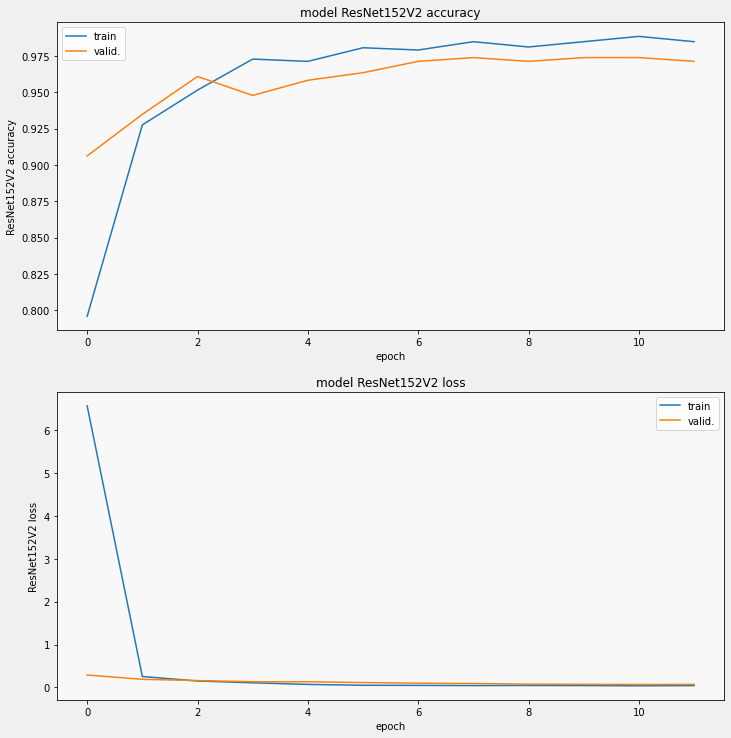

In [ ]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'ResNet152V2 accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'ResNet152V2 loss', 212)

# Train the model(Xception)

In [ ]:
start_time = time.time()
history = model_Xception.fit(training_dataset.repeat(), steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_dataset.repeat(), validation_steps=validation_steps, shuffle=True)
final_accuracy = history.history["val_accuracy"][-5:]

model_Xception_accuracy=round(np.mean(final_accuracy),2)
model_Xception_training_time= round((time.time() - start_time),2)
print("FINAL ACCURACY MEAN(Xception): ", model_Xception_accuracy)
print("TRAINING TIME: ", model_Xception_training_time , " sec")

Epoch 1/12
30/30 [==============================] - 6s 203ms/step - loss: 6.2810 - accuracy: 0.7677 - val_loss: 0.5463 - val_accuracy: 0.9062
Epoch 2/12
30/30 [==============================] - 5s 182ms/step - loss: 0.5010 - accuracy: 0.9057 - val_loss: 0.1700 - val_accuracy: 0.9401
Epoch 3/12
30/30 [==============================] - 5s 183ms/step - loss: 0.1762 - accuracy: 0.9349 - val_loss: 0.1181 - val_accuracy: 0.9531
Epoch 4/12
30/30 [==============================] - 5s 183ms/step - loss: 0.1148 - accuracy: 0.9609 - val_loss: 0.1158 - val_accuracy: 0.9531
Epoch 5/12
30/30 [==============================] - 5s 183ms/step - loss: 0.0880 - accuracy: 0.9609 - val_loss: 0.1109 - val_accuracy: 0.9505
Epoch 6/12
30/30 [==============================] - 5s 183ms/step - loss: 0.0584 - accuracy: 0.9750 - val_loss: 0.1294 - val_accuracy: 0.9583
Epoch 7/12
30/30 [==============================] - 6s 184ms/step - loss: 0.0570 - accuracy: 0.9786 - val_loss: 0.1073 - val_accuracy: 0.9531
Epoch 

# Training and Validation Accuracy Graph(model_Xception)
# Training and Validation Loss Graph(model_Xception)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


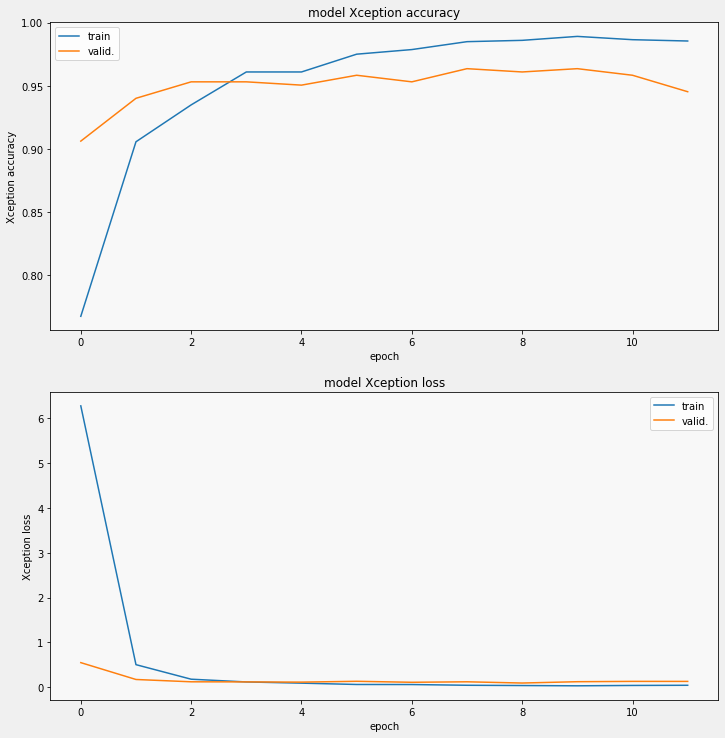

In [ ]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'Xception accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'Xception loss', 212)

# Train the model(VGG16)

In [ ]:
start_time = time.time()
history = model_VGG16.fit(training_dataset.repeat(), steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_dataset.repeat(), validation_steps=validation_steps, shuffle=True)
final_accuracy = history.history["val_accuracy"][-5:]


model_VGG16_accuracy=round(np.mean(final_accuracy),2)
model_VGG16_training_time= round((time.time() - start_time),2)
print("FINAL ACCURACY MEAN(VGG16): ", model_VGG16_accuracy)
print("TRAINING TIME: ", model_VGG16_training_time , " sec")

Epoch 1/12
30/30 [==============================] - 6s 186ms/step - loss: 1.6517 - accuracy: 0.7141 - val_loss: 0.2841 - val_accuracy: 0.9271
Epoch 2/12
30/30 [==============================] - 5s 182ms/step - loss: 0.2315 - accuracy: 0.9115 - val_loss: 0.1890 - val_accuracy: 0.9453
Epoch 3/12
30/30 [==============================] - 5s 183ms/step - loss: 0.1536 - accuracy: 0.9474 - val_loss: 0.1465 - val_accuracy: 0.9557
Epoch 4/12
30/30 [==============================] - 5s 182ms/step - loss: 0.1248 - accuracy: 0.9573 - val_loss: 0.1275 - val_accuracy: 0.9531
Epoch 5/12
30/30 [==============================] - 5s 182ms/step - loss: 0.1015 - accuracy: 0.9656 - val_loss: 0.1247 - val_accuracy: 0.9583
Epoch 6/12
30/30 [==============================] - 5s 182ms/step - loss: 0.0797 - accuracy: 0.9698 - val_loss: 0.1067 - val_accuracy: 0.9609
Epoch 7/12
30/30 [==============================] - 5s 183ms/step - loss: 0.0568 - accuracy: 0.9849 - val_loss: 0.1132 - val_accuracy: 0.9635
Epoch 

# Training and Validation Accuracy Graph(VGG16)
# Training and Validation Loss Graph(VGG16)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


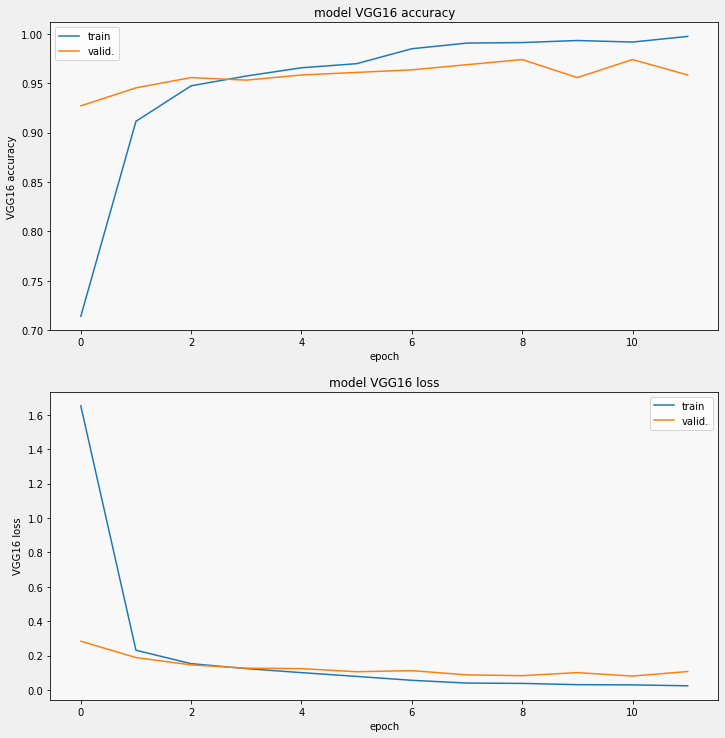

In [ ]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'VGG16 accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'VGG16 loss', 212)

# Train the model(VGG19)

In [ ]:
start_time = time.time()
history = model_VGG19.fit(training_dataset.repeat(), steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_dataset.repeat(), validation_steps=validation_steps, shuffle=True)
final_accuracy = history.history["val_accuracy"][-5:]

model_VGG19_accuracy=round(np.mean(final_accuracy),2)
model_VGG19_training_time= round((time.time() - start_time),2)
print("FINAL ACCURACY MEAN(VGG19): ", model_VGG19_accuracy)
print("TRAINING TIME: ", model_VGG19_training_time , " sec")

Epoch 1/12
30/30 [==============================] - 6s 216ms/step - loss: 2.1160 - accuracy: 0.7010 - val_loss: 0.2734 - val_accuracy: 0.8932
Epoch 2/12
30/30 [==============================] - 6s 211ms/step - loss: 0.2342 - accuracy: 0.9052 - val_loss: 0.1816 - val_accuracy: 0.9401
Epoch 3/12
30/30 [==============================] - 6s 211ms/step - loss: 0.1790 - accuracy: 0.9354 - val_loss: 0.1621 - val_accuracy: 0.9375
Epoch 4/12
30/30 [==============================] - 6s 212ms/step - loss: 0.1308 - accuracy: 0.9568 - val_loss: 0.1476 - val_accuracy: 0.9427
Epoch 5/12
30/30 [==============================] - 6s 211ms/step - loss: 0.1105 - accuracy: 0.9563 - val_loss: 0.1489 - val_accuracy: 0.9375
Epoch 6/12
30/30 [==============================] - 6s 211ms/step - loss: 0.1228 - accuracy: 0.9536 - val_loss: 0.1479 - val_accuracy: 0.9401
Epoch 7/12
30/30 [==============================] - 6s 212ms/step - loss: 0.1025 - accuracy: 0.9630 - val_loss: 0.1413 - val_accuracy: 0.9479
Epoch 

# Training and Validation Accuracy Graph(VGG19)
# Training and Validation Loss Graph(VGG19)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


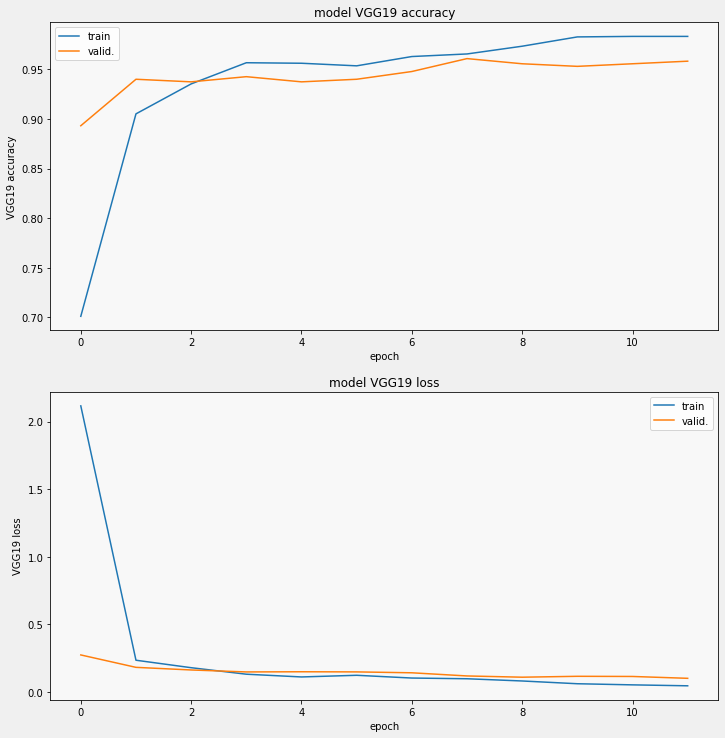

In [ ]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'VGG19 accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'VGG19 loss', 212)

# Train the model(InceptionResNetV2)

In [ ]:
start_time = time.time()
history = model_InceptionResNetV2.fit(training_dataset.repeat(), steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_dataset.repeat(), validation_steps=validation_steps, shuffle=True)
final_accuracy = history.history["val_accuracy"][-5:]

model_InceptionResNetV2_accuracy=round(np.mean(final_accuracy),2)
model_InceptionResNetV2_training_time= round((time.time() - start_time),2)
print("FINAL ACCURACY MEAN(InceptionResNetV2): ", model_InceptionResNetV2_accuracy)
print("TRAINING TIME: ", model_InceptionResNetV2_training_time , " sec")

Epoch 1/12
30/30 [==============================] - 9s 315ms/step - loss: 4.7015 - accuracy: 0.6854 - val_loss: 0.3888 - val_accuracy: 0.8411
Epoch 2/12
30/30 [==============================] - 7s 227ms/step - loss: 0.3743 - accuracy: 0.8510 - val_loss: 0.2510 - val_accuracy: 0.8906
Epoch 3/12
30/30 [==============================] - 7s 227ms/step - loss: 0.2554 - accuracy: 0.8979 - val_loss: 0.2225 - val_accuracy: 0.9271
Epoch 4/12
30/30 [==============================] - 7s 227ms/step - loss: 0.2133 - accuracy: 0.9177 - val_loss: 0.1833 - val_accuracy: 0.9401
Epoch 5/12
30/30 [==============================] - 7s 227ms/step - loss: 0.1785 - accuracy: 0.9292 - val_loss: 0.2085 - val_accuracy: 0.9167
Epoch 6/12
30/30 [==============================] - 7s 226ms/step - loss: 0.1514 - accuracy: 0.9396 - val_loss: 0.1869 - val_accuracy: 0.9167
Epoch 7/12
30/30 [==============================] - 7s 226ms/step - loss: 0.1257 - accuracy: 0.9552 - val_loss: 0.1644 - val_accuracy: 0.9505
Epoch 

# Training and Validation Accuracy Graph(InceptionResNetV2)
# Training and Validation Loss Graph(InceptionResNetV2)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


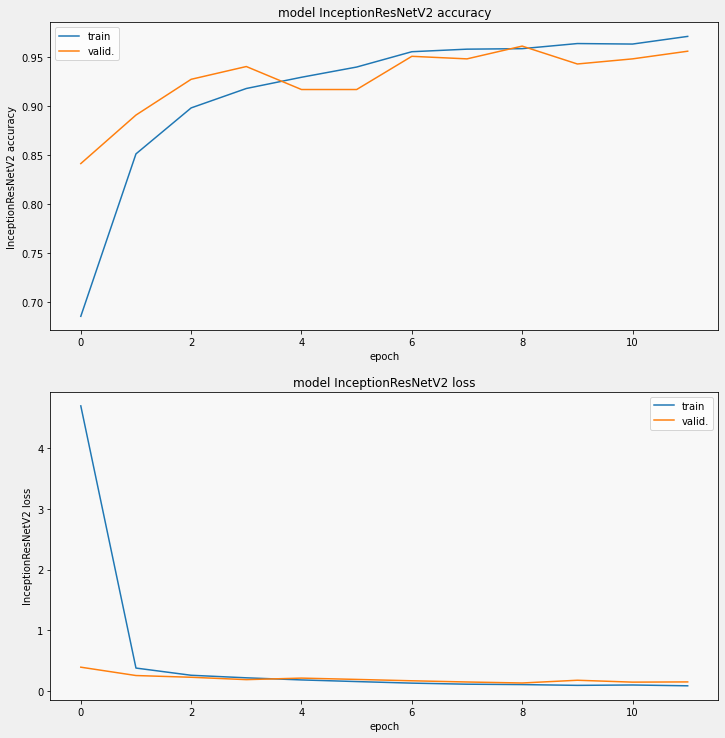

In [ ]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'InceptionResNetV2 accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'InceptionResNetV2 loss', 212)

# Train the model(InceptionV3)

In [ ]:
start_time = time.time()
history = model_InceptionV3.fit(training_dataset.repeat(), steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_dataset.repeat(), validation_steps=validation_steps, shuffle=True)
final_accuracy = history.history["val_accuracy"][-5:]

model_InceptionV3_accuracy=round(np.mean(final_accuracy),2)
model_InceptionV3_training_time= round((time.time() - start_time),2)
print("FINAL ACCURACY MEAN(InceptionV3): ", model_InceptionV3_accuracy)
print("TRAINING TIME: ", model_InceptionV3_training_time , " sec")

Epoch 1/12
30/30 [==============================] - 4s 139ms/step - loss: 5.2977 - accuracy: 0.7536 - val_loss: 0.4458 - val_accuracy: 0.8984
Epoch 2/12
30/30 [==============================] - 3s 104ms/step - loss: 0.3578 - accuracy: 0.8875 - val_loss: 0.1997 - val_accuracy: 0.9349
Epoch 3/12
30/30 [==============================] - 3s 103ms/step - loss: 0.1947 - accuracy: 0.9172 - val_loss: 0.2150 - val_accuracy: 0.9271
Epoch 4/12
30/30 [==============================] - 3s 103ms/step - loss: 0.1655 - accuracy: 0.9365 - val_loss: 0.2071 - val_accuracy: 0.9193
Epoch 5/12
30/30 [==============================] - 3s 104ms/step - loss: 0.1446 - accuracy: 0.9443 - val_loss: 0.1622 - val_accuracy: 0.9427
Epoch 6/12
30/30 [==============================] - 3s 104ms/step - loss: 0.1088 - accuracy: 0.9604 - val_loss: 0.2083 - val_accuracy: 0.9271
Epoch 7/12
30/30 [==============================] - 3s 104ms/step - loss: 0.1117 - accuracy: 0.9521 - val_loss: 0.1832 - val_accuracy: 0.9349
Epoch 

# Training and Validation Accuracy Graph(InceptionV3)
# Training and Validation Loss Graph(InceptionV3)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


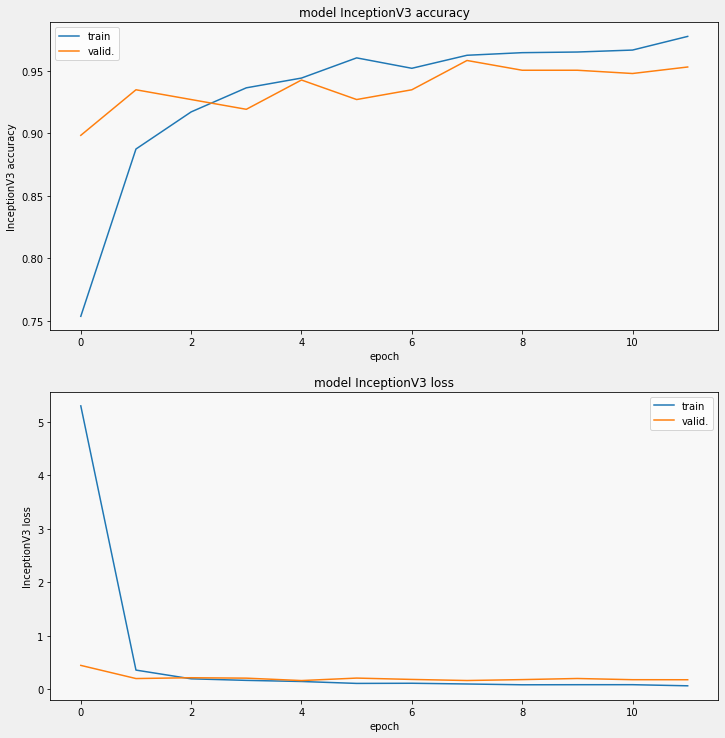

In [ ]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'InceptionV3 accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'InceptionV3 loss', 212)

In [ ]:
training_details = [ 
        { 
        "Model": [{"Accuracy": model_MobileNetV2_accuracy, "Training Time": model_MobileNetV2_training_time} 
                   ], 
        "Name": "MobileNetV2"
        }, 
        { 
        "Model": [{"Accuracy": model_ResNet50V2_accuracy, "Training Time": model_ResNet50V2_training_time}                    
                  ], 
        "Name": "ResNet50V2"
        },
        { 
        "Model": [{"Accuracy": model_ResNet101V2_accuracy, "Training Time": model_ResNet101V2_training_time}                    
                  ], 
        "Name": "ResNet101V2"
        },
        { 
        "Model": [{"Accuracy": model_ResNet152V2_accuracy, "Training Time": model_ResNet152V2_training_time}                    
                  ], 
        "Name": "ResNet152V2"
        },
        { 
        "Model": [{"Accuracy": model_Xception_accuracy, "Training Time": model_Xception_training_time}                    
                  ], 
        "Name": "Xception"
        },
        { 
        "Model": [{"Accuracy": model_VGG16_accuracy, "Training Time": model_VGG16_training_time}                    
                  ], 
        "Name": "VGG16"
        },
        { 
        "Model": [{"Accuracy": model_VGG19_accuracy, "Training Time": model_VGG19_training_time}                    
                  ], 
        "Name": "VGG19"
        },
        { 
        "Model": [{"Accuracy": model_InceptionResNetV2_accuracy, "Training Time": model_InceptionResNetV2_training_time}                    
                  ], 
        "Name": "InceptionResNetV2"
        },
        { 
        "Model": [{"Accuracy": model_InceptionV3_accuracy, "Training Time": model_InceptionV3_training_time}                    
                  ], 
        "Name": "InceptionV3"
        }
       ] 

In [ ]:
training_details

[{'Model': [{'Accuracy': 0.98, 'Training Time': 36.05}],
  'Name': 'MobileNetV2'},
 {'Model': [{'Accuracy': 0.96, 'Training Time': 49.59}], 'Name': 'ResNet50V2'},
 {'Model': [{'Accuracy': 0.95, 'Training Time': 80.17}],
  'Name': 'ResNet101V2'},
 {'Model': [{'Accuracy': 0.97, 'Training Time': 113.72}],
  'Name': 'ResNet152V2'},
 {'Model': [{'Accuracy': 0.96, 'Training Time': 70.79}], 'Name': 'Xception'},
 {'Model': [{'Accuracy': 0.97, 'Training Time': 69.37}], 'Name': 'VGG16'},
 {'Model': [{'Accuracy': 0.96, 'Training Time': 79.63}], 'Name': 'VGG19'},
 {'Model': [{'Accuracy': 0.95, 'Training Time': 95.19}],
  'Name': 'InceptionResNetV2'},
 {'Model': [{'Accuracy': 0.95, 'Training Time': 43.18}],
  'Name': 'InceptionV3'}]

In [ ]:
model_name=['MobileNetV2', 'ResNet50V2','ResNet101V2','ResNet152V2','Xception','VGG16','VGG19','InceptionResNetV2','InceptionV3']
model_accuracy=[model_MobileNetV2_accuracy, model_ResNet50V2_accuracy ,model_ResNet101V2_accuracy,model_ResNet152V2_accuracy,model_Xception_accuracy,model_VGG16_accuracy,model_VGG19_accuracy,model_InceptionResNetV2_accuracy,model_InceptionV3_accuracy]
model_training_time=[model_MobileNetV2_training_time,model_ResNet50V2_training_time,model_ResNet101V2_training_time,model_ResNet152V2_training_time,model_Xception_training_time,model_VGG16_training_time,model_VGG19_training_time,model_InceptionResNetV2_training_time,model_InceptionV3_training_time]

In [ ]:
import pandas as pd 

df = pd.DataFrame(list(zip(model_name, model_accuracy,model_training_time )), 
               columns =['Model Name', 'Accuracy', 'Training Time']) 
df 

Model Name  Accuracy  Training Time
0        MobileNetV2      0.98          36.05
1         ResNet50V2      0.96          49.59
2        ResNet101V2      0.95          80.17
3        ResNet152V2      0.97         113.72
4           Xception      0.96          70.79
5              VGG16      0.97          69.37
6              VGG19      0.96          79.63
7  InceptionResNetV2      0.95          95.19
8        InceptionV3      0.95          43.18

In [ ]:
df['Training Time'] = np.log(df['Training Time'])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

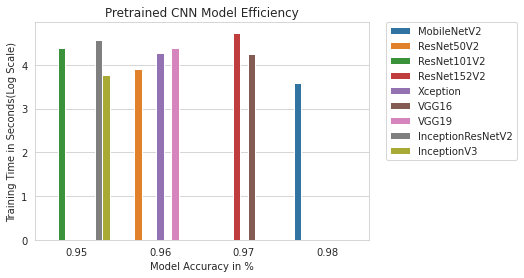

In [ ]:
ax=sns.barplot(y="Training Time", x="Accuracy", hue="Model Name", data=df)
ax.set_title('Pretrained CNN Model Efficiency')
ax.set_ylabel('Training Time in Seconds(Log Scale)')
ax.set_xlabel('Model Accuracy in %')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Predictions

[b'Late_Blight', b'Healthy', b'Late_Blight', b'Early_Blight', b'Early_Blight', b'Early_Blight', b'Early_Blight', b'Early_Blight', b'Late_Blight']


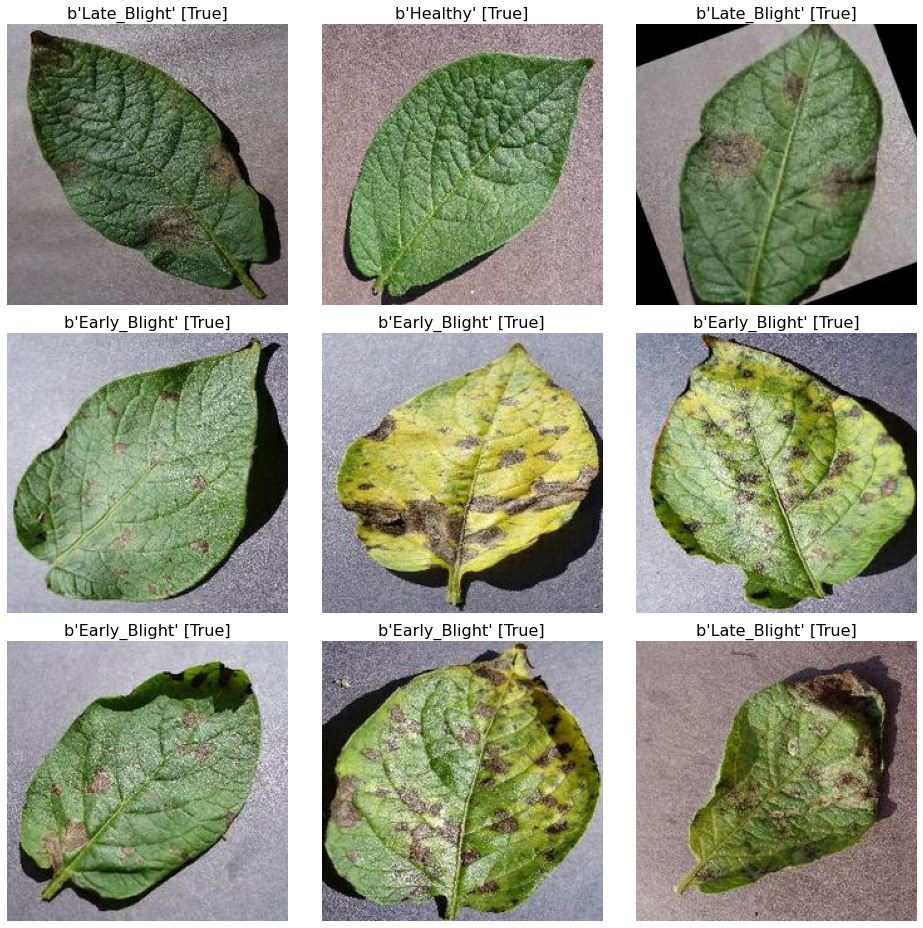

In [ ]:
# random input: execute multiple times to change results
#print(load_dataset(validation_filenames.skip(np.random.randint(300)))
potatos, labels = dataset_to_numpy_util(load_dataset(validation_filenames).skip(np.random.randint(16)), 9)

predictions = model_MobileNetV2.predict(potatos, steps=1 )
print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())
#print(validation_filenames)

display_9_images_with_predictions(potatos, predictions, labels)

# Save The Model



In [ ]:
# Save JSON config to disk
json_config = model_MobileNetV2.to_json()
with open('/content/drive/My Drive/Plant_Disease_Clinic/Model/Potato/Potato_model_config_MobileNetV2.json', 'w') as json_file:
    json_file.write(json_config)
# Save weights to disk
model_MobileNetV2.save_weights('/content/drive/My Drive/Plant_Disease_Clinic/Model/Potato/Potato_weights_MobileNetV2.h5')

# Reload the model from the 2 files we saved
with open('/content/drive/My Drive/Plant_Disease_Clinic/Model/Potato/Potato_model_config_MobileNetV2.json') as json_file:
     json_config = json_file.read()
my_saved_model = tf.keras.models.model_from_json(json_config)
my_saved_model.load_weights('/content/drive/My Drive/Plant_Disease_Clinic/Model/Potato/Potato_weights_MobileNetV2.h5')


# Load The Saved Model

In [ ]:
print(my_saved_model.summary())
print(my_saved_model.input_shape)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               16056576  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 18,315,331
Trainable params: 16,057,347
Non-trainable params: 2,257,984
_________________________________________________________________
None
(None, 224, 224, 3)


# Predict From Saved Model

[b'Early_Blight', b'Late_Blight', b'Early_Blight', b'Late_Blight', b'Late_Blight', b'Late_Blight', b'Early_Blight', b'Early_Blight', b'Early_Blight']


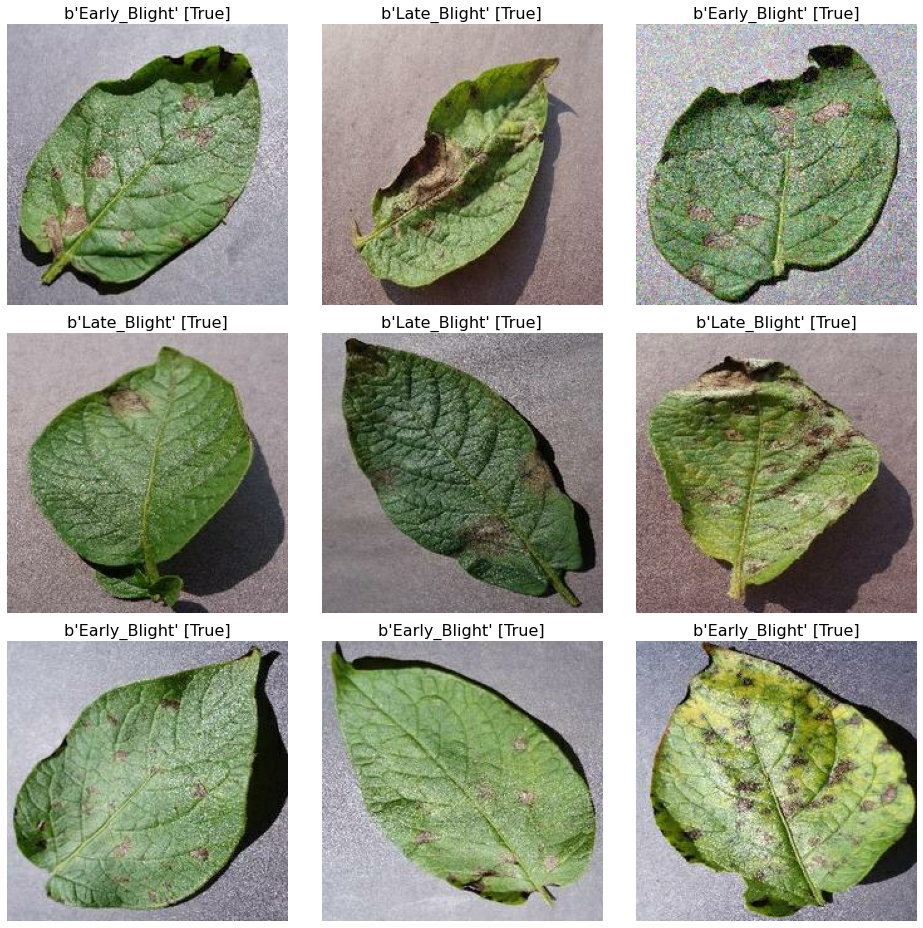

In [ ]:
# random input: execute multiple times to change results
potatos, labels = dataset_to_numpy_util(load_dataset(validation_filenames).skip(np.random.randint(30)), 9)
predictions = my_saved_model.predict(potatos, steps=1 )
print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())
display_9_images_with_predictions(potatos, predictions, labels)